<a href="https://colab.research.google.com/github/MatthewC00273575/Data-Science/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
from xml.etree import ElementTree as ET
import cv2
import matplotlib.pyplot as plt

# Load dataset (assumes unzipped 'fruit-images' folder from Kaggle)
data_dir = '/content/train'  # Adjust path as needed
images = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.jpg')]
annotations = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.xml')]

# Parse XML annotations
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    return {
        'filename': root.find('filename').text,
        'objects': [{'name': obj.find('name').text,
                     'bbox': [int(obj.find('bndbox').find(k).text) for k in ['xmin', 'ymin', 'xmax', 'ymax']]}
                    for obj in root.findall('object')]
    }

# Build dataset
dataset = [parse_xml(ann) for ann in annotations]
print(f"Loaded {len(dataset)} samples")
print(dataset[0])  # Example entry

Loaded 240 samples
{'filename': 'apple_66.jpg', 'objects': [{'name': 'apple', 'bbox': [46, 59, 397, 432]}, {'name': 'apple', 'bbox': [363, 83, 770, 514]}]}


In [ ]:
import tensorflow as tf
import numpy as np

# Load and preprocess image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (320, 320))  # SSDlite MobileNet V2 input size
    img = img / 255.0  # Normalize
    return img

# Prepare dataset (simplified for demo; full prep needs TF records)
images_preprocessed = [preprocess_image(os.path.join(data_dir, d['filename'])) for d in dataset]
labels = [d['objects'] for d in dataset]

# Convert to numpy for model input
X = np.array(images_preprocessed)
print(f"Preprocessed shape: {X.shape}")

Preprocessed shape: (240, 320, 320, 3)


In [ ]:
# Load pre-trained model
model_path = 'ssdlite_mobilenet_v2_coco/saved_model'
model = tf.saved_model.load(model_path)
infer = model.signatures['serving_default']

# Preprocess without normalization (keep uint8)
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (320, 320))  # Match SSDlite input size
    return img  # Stays uint8 (0-255)

# Load and preprocess one image
sample_img_path = os.path.join(data_dir, dataset[0]['filename'])
sample_img = preprocess_image(sample_img_path)
sample_img = tf.convert_to_tensor(sample_img[np.newaxis, ...], dtype=tf.uint8)  # Shape (1, 320, 320, 3)

# Run inference with correct keyword
detections = infer(inputs=sample_img)  # Use 'inputs=' as per signature

# Extract detections
boxes = detections['detection_boxes'].numpy()[0]
scores = detections['detection_scores'].numpy()[0]
classes = detections['detection_classes'].numpy()[0].astype(int)
print(f"Top detection: Class {classes[0]}, Score {scores[0]:.3f}")

Top detection: Class 53, Score 0.864


In [ ]:
# COCO class labels (subset relevant to fruits and common mislabels)
COCO_CLASSES = {
    1: 'person', 44: 'bottle', 46: 'cup', 47: 'chair', 50: 'dining table',
    52: 'banana', 53: 'apple', 55: 'orange', 62: 'pizza'
}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, f"Unknown ({class_id})")

banana_84.jpg: Top detection - banana (Score: 0.963)
apple_77.jpg: Top detection - apple (Score: 0.770)
orange_79.jpg: Top detection - orange (Score: 0.922)
apple_82.jpg: Top detection - apple (Score: 0.896)
banana_94.jpg: Top detection - Unknown (34) (Score: 0.525)
apple_84.jpg: Top detection - apple (Score: 0.940)
orange_77.jpg: Top detection - orange (Score: 0.947)
banana_79.jpg: Top detection - banana (Score: 0.977)
apple_94.jpg: Top detection - apple (Score: 0.869)
apple_95.jpg: Top detection - apple (Score: 0.927)
orange_80.jpg: Top detection - orange (Score: 0.950)
mixed_24.jpg: Top detection - banana (Score: 0.926)
banana_83.jpg: Top detection - banana (Score: 0.965)
apple_81.jpg: Top detection - apple (Score: 0.924)
apple_90.jpg: Top detection - apple (Score: 0.952)
orange_78.jpg: Top detection - orange (Score: 0.906)
banana_90.jpg: Top detection - banana (Score: 0.960)
orange_86.jpg: Top detection - orange (Score: 0.975)
apple_80.jpg: Top detection - apple (Score: 0.984)
oran

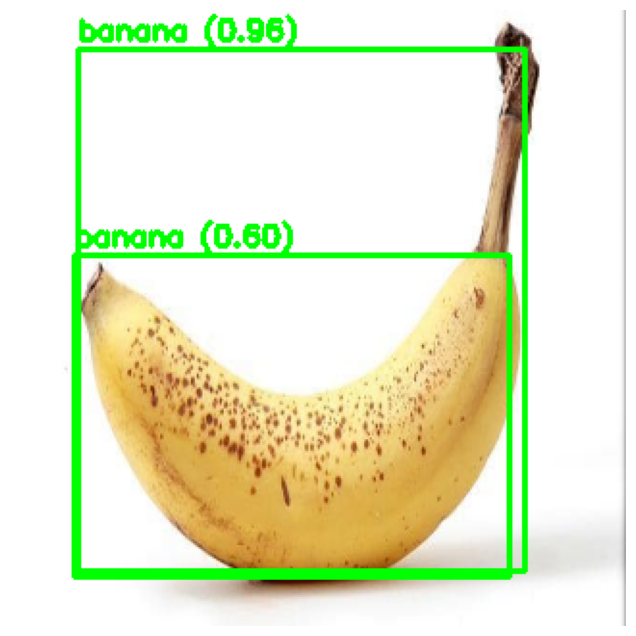

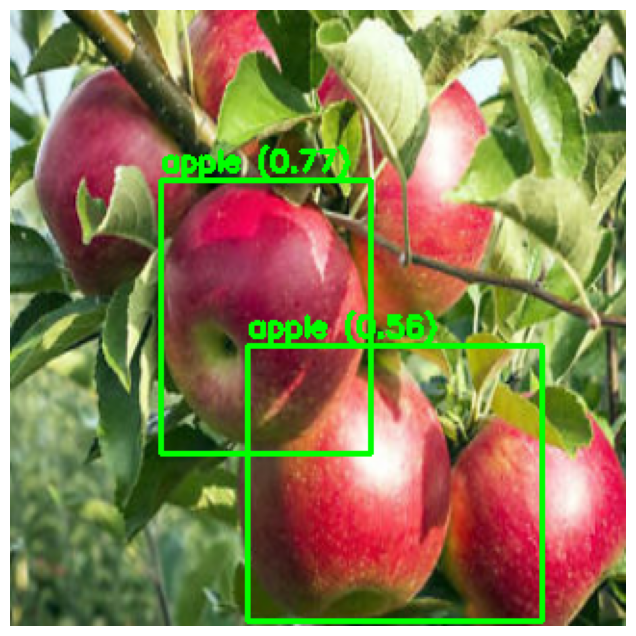

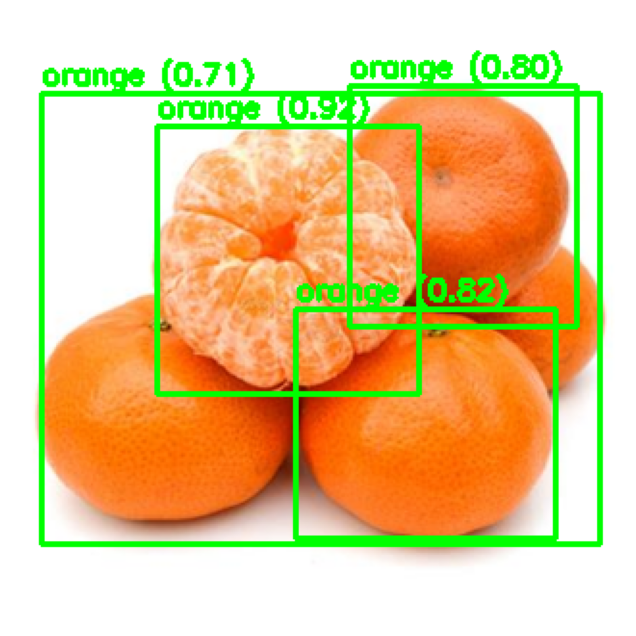

In [ ]:
# Run inference on test images
test_predictions = []
for img_path in test_images:
    img = preprocess_image(img_path)
    img_tensor = tf.convert_to_tensor(img[np.newaxis, ...], dtype=tf.uint8)
    detections = infer(inputs=img_tensor)
    pred = {
        'filename': os.path.basename(img_path),
        'boxes': detections['detection_boxes'].numpy()[0],
        'scores': detections['detection_scores'].numpy()[0],
        'classes': detections['detection_classes'].numpy()[0].astype(int)
    }
    test_predictions.append(pred)
    top_class = pred['classes'][0]
    top_score = pred['scores'][0]
    print(f"{pred['filename']}: Top detection - {get_class_name(top_class)} (Score: {top_score:.3f})")

# Visualize first 3
for i in range(min(3, len(test_images))):
    pred = test_predictions[i]
    img = preprocess_image(test_images[i])
    visualize_detection(img, pred['boxes'], pred['classes'], pred['scores'])

In [ ]:
# Define test directory
test_dir = '/content/test'
test_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.jpg')]

# Parse test annotations (if present)
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    return {
        'filename': root.find('filename').text,
        'objects': [{'name': obj.find('name').text,
                     'bbox': [int(obj.find('bndbox').find(k).text) for k in ['xmin', 'ymin', 'xmax', 'ymax']]}
                    for obj in root.findall('object')]
    }

test_annotations = [parse_xml(os.path.join(test_dir, f.replace('.jpg', '.xml')))
                    for f in os.listdir(test_dir) if f.endswith('.jpg') and os.path.exists(os.path.join(test_dir, f.replace('.jpg', '.xml')))]
print(f"Loaded {len(test_images)} test images, {len(test_annotations)} with annotations")

Loaded 60 test images, 60 with annotations


In [ ]:
# Preprocess function
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (320, 320))  # SSDlite input size
    return img  # uint8

# Run inference on all test images
test_predictions = []
for img_path in test_images:
    img = preprocess_image(img_path)
    img_tensor = tf.convert_to_tensor(img[np.newaxis, ...], dtype=tf.uint8)
    detections = infer(inputs=img_tensor)
    test_predictions.append({
        'filename': os.path.basename(img_path),
        'boxes': detections['detection_boxes'].numpy()[0],
        'scores': detections['detection_scores'].numpy()[0],
        'classes': detections['detection_classes'].numpy()[0].astype(int)
    })
print(f"Ran inference on {len(test_predictions)} images")

Ran inference on 60 images


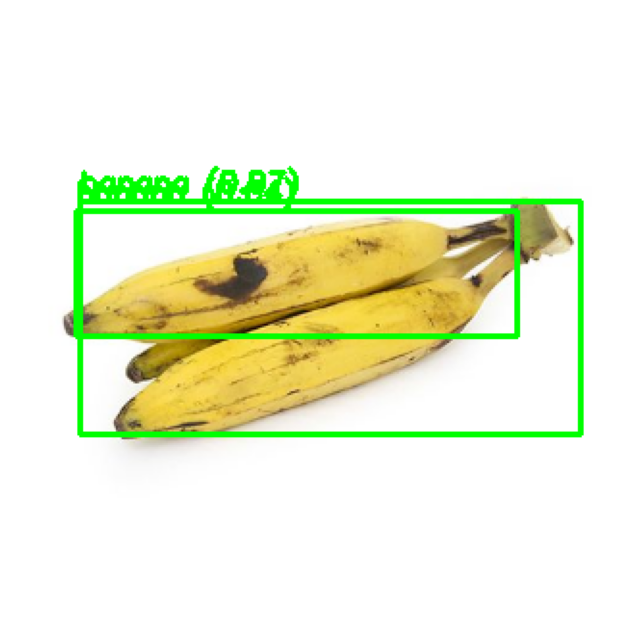

Image: banana_80.jpg


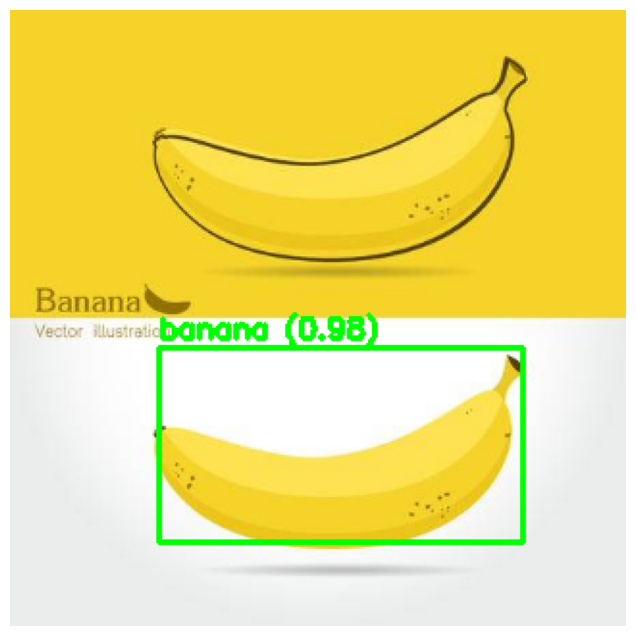

Image: banana_93.jpg


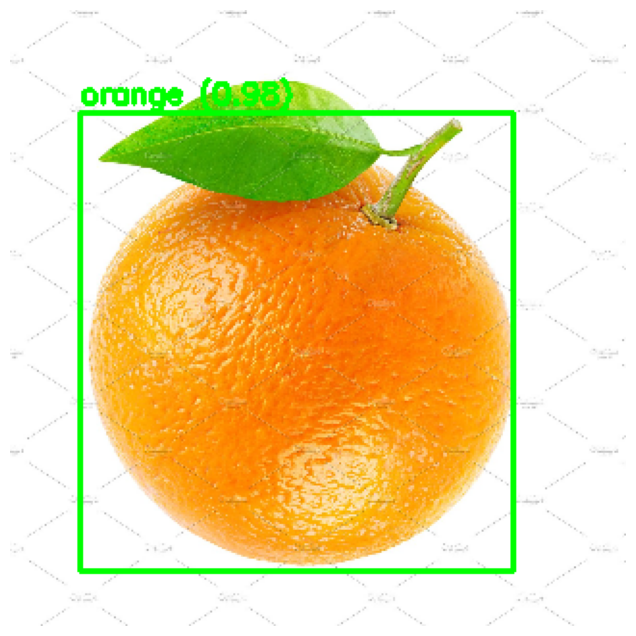

Image: orange_95.jpg


In [ ]:
import random

# Visualize 3 random test images
num_to_show = 3
random_indices = random.sample(range(len(test_images)), min(num_to_show, len(test_images)))  # Pick 3 unique random indices

for i in random_indices:
    img = preprocess_image(test_images[i])
    pred = test_predictions[i]
    visualize_detection(img, pred['boxes'], pred['classes'], pred['scores'], threshold=0.5)
    print(f"Image: {pred['filename']}")